In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Uncostrained Model for Scalar-on-Function Applications 

$$y_{i}=\int_{T}x_{i}(t)\beta(t)dt+\epsilon_{i}$$

### in this section:
Definition of the Class "data_generator", using the following input
1. *T1, T2*, the extremes of the interval of interest T
2. *g*, setting the discretization of T, we will store $$\{ T_{1},T_{1}+\frac{T_{2}-T_{1}}{g},T_{1}+2\frac{T_{2}-T_{1}}{g},...,T_{2}\}$$
3. *beta*, the actual functional parameter, as a list of values
4. *n*, the number of observations for covariate
5. *covariates_kernel*, the kernel of the functional covariate
6. *sigma*, the variance of the noise term in the regression model,

containing the function *i_o*, which return as output
1. *x*, a $n\times g$ np.array storing the covariates values
2. *y*, the actual scalar response, estimated by perturbating the true value obtained by means of the regression model.

In [2]:
class data_generator:
    def __init__(self, T1, T2, g, beta, n, covariates_kernel, sigma):
        self.T = np.linspace(T1,T2,g)
        self.K = np.fromfunction(np.vectorize(lambda s, t: covariates_kernel(self.T[s], self.T[t])), (g, g), dtype=int)
        self.g = g
        self.n = n
        self.beta = beta
        self.sigma = sigma
    
    def grid(self):
        return self.T
    
    def i_o(self):
        x = np.random.multivariate_normal(np.zeros(self.g), self.K, self.n)
        y = np.fromfunction(np.vectorize(lambda i: np.trapz(x[i,:]*self.beta,self.T)+np.random.normal(0,self.sigma,1)), (self.n,), dtype=int)
        return x,y
        

### dataset simulation:
1. $T=[-3,3].$
2. Actual functional parameter $$\beta_{t} = \sin (\frac{\pi}{4}t).$$
3. Centered gaussian covariate $x_{i}$ with $i\in\{1,...,100\}$ with kernel $$k_{x}(s,t)=e^{-2(t-s)^{2}}.$$
4. Scalar response $y_{i}$ according to the regression model, perturbated with $\epsilon_{i}\sim N[0,1].$

In [3]:
# EXAMPLE

# input
a = -3
b = 3
g = 100
n = 100
sigma = 1
beta = np.sin(np.linspace(a,b,g)*np.pi/4)
def covariates_kernel(s,t):
    return np.exp(-2*(t-s)**2)
def prior_kernel(s,t):
    return np.exp(-(t-s)**2)

#generation
data = data_generator(b,a,g,beta,n,covariates_kernel, sigma)
T = data.grid()
x,y = data.i_o()

# Posterior Mean and Covariance
### What you see in this section:
The class *Posterior* returns the constrained model outcomes thanks to the functions
1. *posterior_mean_cov*, returning the posterior mean and covariance
2. *fitted_values*, returning the values $\hat{y}$ predicted by the constrained model

In [4]:
class posterior:
    def __init__(self, T, x, y, prior_kernel,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.prior_kernel = prior_kernel
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.sigma = sigma
        self.K = np.fromfunction(np.vectorize(lambda s, t: self.prior_kernel(self.T[s], self.T[t])), (self.g, self.g), dtype=int)
    
    def Lx(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = np.trapz(self.K[t, :] * self.x[i,:],self.T)
        return L
    
    def R(self,i, j):
        Ri = np.fromfunction(np.vectorize(lambda t: np.trapz(self.K[:,t] * self.x[i,:],self.T)), (self.g,), dtype=int)
        Rij = np.trapz(Ri * self.x[j,:],self.T)
        return  Rij
    
    def cov(self):
        return np.fromfunction(np.vectorize(lambda i, j: self.R(i, j)), (self.n, self.n), dtype=int)
    
    def posterior_mean_cov(self):
        inv = np.linalg.inv(self.cov() + self.sigma * np.identity(self.n))
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx(t)),inv),self.y)
            return mean
        def Kstar(s,t):
            cov = self.K[s,t] - np.dot(np.dot(np.transpose(self.Lx(s)),inv),self.Lx(t))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.cov() + self.sigma * np.identity(self.n))
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: np.trapz(self.x[i,:]*m,self.T)), (self.n,), dtype=int)


In [5]:
# EXAMPLE
p = posterior(T, x, y, prior_kernel, sigma)
m, cov = p.posterior_mean_cov()
fitted = p.fitted_values()

# Goodness Check

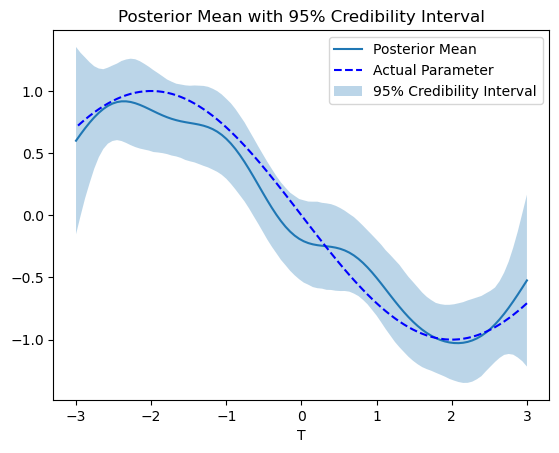

In [6]:
samples = np.random.multivariate_normal(m, cov, size=10000)

up = np.zeros(m.shape[0])
down = np.zeros(m.shape[0])

for i in range(m.shape[0]):
    up[i]=np.quantile(samples[:,i],0.975)
    down[i]=np.quantile(samples[:,i],0.025)

plt.plot(T,m, label='Posterior Mean')
plt.plot(T,beta,'--',label='Actual Parameter',c='b')
plt.fill_between(T, down, up, alpha=0.3, label='95% Credibility Interval')

plt.title('Posterior Mean with 95% Credibility Interval')
plt.xlabel('T')
plt.legend()
plt.show()